# Value Functions and Numerical Solutions

Here you will learn how to deal with Value Functions that characterize infinite-horizon problems.

## A simple consumption-savings problem

In Economics (warning: not only Macro!) you will often encounter problems that look like the following:

\begin{align*}
    V(k) = \max_{c, k'} &\; \left( u(c) + \beta V(k') \right) \\
        \text{s.t.} &\; \begin{cases}
            c + k' \leq f(k) + (1 - \delta) k \\
            f(k) = k^\alpha \\
            c \geq 0.
        \end{cases}
\end{align*}

Sometimes these problems are not easy to solve, and more often they are just the fundamental step on top of which a bigger problem sits.

In this TA session, we will learn how to numerically tackle such problem.
We will use the following packages:

In [1]:
import numpy as np  # N-dimensional arrays (e.g., vectors, matrices)
from matplotlib import pyplot as plt  # for some graphics
from time import time  # to keep track of... time!

There are three ways we can tackle this problem:

- Value Function Iteration (VFI);
- Policy Function Iteration (PFI); and
- "Direct" projection.

In this file, we will see all three of them and we will go through the steps of 

## Value Function Iteration

Value Function Iteration (VFI) consists of iterating the contraction operator $\mathbf{T} V(\cdot)$ many times.
As you know from theory, if $V(\cdot)$ is indeed a contraction mapping, then we can construct a sequence ${\left( V^{(n)}(k) \right)}_{n=0}^{\infty}$ such that $V^{(n+1)}(k) = \mathbf{T} V^{(n)}(k)$.
The sequence is convergent and the limit is $V(k)$.

All we do numerically is to blindly apply the procedure.
The catch in this setting is that $V(k)$ is a function.
This means that we have to apply the procedure to all values $V$, one for each (interesting) value of $k$.

How do we do this?

- Define a set of points $k \in \mathcal{K} \equiv \{ k_1, k_2, ..., k_{n_k} \}$ for which the problem makes sense
- Start from a guess $V^{(0)}(k)$, defined for each value of $k$.
- At each iteration $n$:
    - Compute $c = k^\alpha + (1 - \delta) k - k'$, one for each $k$ and for all possible values of $k'$
    - Rule out invalid values of $c$ (e.g., $c < 0$)
    - Maximize the quantity $u(c) + \beta V^{(n)}(k)$
    - The max will be $V^{(n+1)}(k)$, the argmax will be $k'$
    - If $\max_k(|V^{(n+1)}(k) - V^{(n)}(k)|) > \varepsilon$, then go to iteration $n+1$, otherwise stop the loop (for some arbitrary, small and positive real number $\varepsilon$).

Before entering the specific commands that constitute the algorithm, we need to calibrate the model.
This means choosing parameter values according to some criterion.
As we are not interested here in how to calibrate, we will just skip the rationale behind the numbers and we just trust some given values.

In [2]:
gamma = 1.5  # the CRRA parameter
delta = 0.1  # capital depreciation
beta = 0.95  # discount rate
alpha = 0.3  # exponetiator in production function

tolerance = 1e-6  # the \varepsilon in the text above

u = lambda c : c ** (1 - gamma) / (1 - gamma)  # the utility function

Now we start coding the main part of the algorithm.

- _Define a set of points $k \in {k_1, k_2, ..., k_{n_k}}$ for which the problem makes sense_

We want to choose a grid for capital.
A natural choice in the context of the Neoclassical Growth Model (the one we're dealing with here) is to center the interesting values of capital around the steady state value.

In [3]:
N = 1000  # number of grid points

k_ss = ((1 - (1-delta) * beta) / (alpha * beta)) ** (1 / (alpha-1))

k_lo, k_hi = np.array([0.1, 1.9]) * k_ss  # using the unpacking feature of Python
K = np.linspace(start=k_lo, stop=k_hi, num=N)

Next up, we want to formulate a guess $v^{(0)}(k)$.

- _Start from a guess $V^{(0)}(k)$, defined for each value of $k$_

As we are exploiting the contraction mapping theorem, we know that the initial guess is irrelevant for convergence of the algorithm.
The worst that might happen is that the algorithm will take a few extra iterations.

Also, it is good practice to preallocate RAM space for the variables we will be working with.

In what follows, we map $V^{(n)}(k)$ to the variable `V_old` and $V^{(n+1)}(k)$ to `V`.
It is also useful to define a vector `dr` (Decision Rule) that will contain the indices for the policy function (this will be clearer later).
Note that both `V_old` and `V` should have as many elements as the cardinality of the discretized state space (here, we only have one state variable, with `N` grid points).

In [4]:
V_old = np.zeros((N,))
V = np.zeros((N,))
dr = np.zeros((N,), dtype=int)

Now we want to define the convergence criterion and a threshold value for this criterion.
It will be clearer later, so we now skip the explanation of the parameter choice.
The only thing worth noting here is that we map the parameter $\varepsilon$ above to the variable `tolerance`.

In [5]:
criterion = 1
tolerance = 1e-6

This is the moment we enter the loop.
As we need to run the iterations "until" a certain condition is met, we use the `while` statement.
In the code that follows, each line of the `while` code block corresponds to a bullet point among the following:

- _Compute $c = k^\alpha + (1 - \delta) k - k'$, one for each $k$_
- _Rule out invalid values of $c$ (e.g., $c < 0$)_
- _Maximize the quantity $u(c) + \beta V^(n)(k)$_
- _The max will be $V^{(n+1)}(k)$, the argmax will be $k'$_
- _If $\max_k(|V^{(n+1)}(k) - V^{(n)}(k)|) > \varepsilon$, then go to iteration $n+1$, otherwise stop the loop_

In [6]:
n_iter = 0
t0 = time()

while criterion > tolerance:
    n_iter += 1
    for i in range(N):
        C = (K[i] ** alpha) + (1 - delta) * K[i] - K
        negative_C = C < 0
        C[negative_C] = np.nan
        objective = u(C) + beta * V_old
        V[i] = np.nanmax(objective)
        dr[i] = np.nanargmax(objective)
    criterion = np.max(np.abs(V - V_old))
    V_old[:] = V

t1 = time()

print('VFI algorithm took {0:0d} iterations and {1:.2f} seconds.'.format(n_iter, t1 - t0))

VFI algorithm took 285 iterations and 25.18 seconds.


Here it is.
We solved the problem.
As you can see, it took a while to the algorithm to converge.
This time is highly dependent on the number of grid points that you use to discretize your state space.
If your are interested in algorithms (intended as a domain of mathematics and computer science), VFI is a _NP-hard_ problem --- much like asking a computer to solve chess.

Now it is time to figure out why we ended up solving this problem.
The interesting object here is the set of policy functions.
In our example, we have two of them: $c(k)$ and $k'(k)$.
VFI per se focuses on getting $V(k)$, which is not very interesting (unless you do welfare analysis).

Note that `np.argmax` returns an index over the set of possible values of $k$.
So, the contents of `dr` will be integer number ranging from `0` to `N-1`. 
These are not the values of $k'(k)$, so we need to obtain them.

Obtaining the policy function $c(k)$ is trivial once you have $k'(k)$: just use the budget constraint.

In [7]:
K_opt = K[dr]
C_opt = K ** alpha + (1-delta) * K - K_opt

How do we read these vectors?
The value `K_opt[i]` will be the optimal value $k'$ for a given capital stock level `K[i]`.
So, what maps values of `K_opt` into values of `K` is the position in the vector.
This will be clear with the plots.

Now it is time to check our results.
We do plots here to verify that we obtained a sensible solution.
What do we expect?

- A concave value function $V(k)$
- A set of concave policy functions $c(k)$ and $k'(k)$
- The policy function for capital $k'(k)$ should cross the 45-degree line at the steady state value of capital `k_ss`

There are obviously other mathematical features we could use to validate our results, but we will abstract from them in this example.

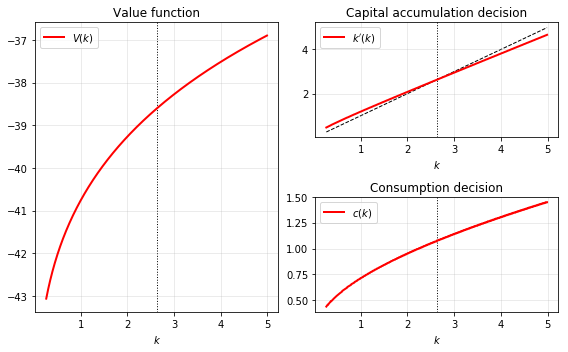

In [11]:
fig = plt.subplots(figsize=(8, 5))
ax = [None, None, None]
pltgrid = (2, 4)

ax[0] = plt.subplot2grid(pltgrid, (0, 0), rowspan=2, colspan=2)
ax[1] = plt.subplot2grid(pltgrid, (0, 2), colspan=2)
ax[2] = plt.subplot2grid(pltgrid, (1, 2), colspan=2)

ax[0].plot(K, V,     linewidth=2, color='red',   label=r'$V(k)$')
ax[1].plot(K, K_opt, linewidth=2, color='red',   label=r"$k'(k)$", zorder=2)
ax[2].plot(K, C_opt, linewidth=2, color='red',   label=r'$c(k)$')
ax[1].plot(K, K,     linewidth=1, color='black', linestyle='dashed', zorder=1)

ax[0].set_title('Value function')
ax[1].set_title('Capital accumulation decision')
ax[2].set_title('Consumption decision')

for a in range(3):
    ax[a].axvline(k_ss, linewidth=1, color='black', linestyle='dotted', zorder=1)
    ax[a].grid(alpha=0.3)
    ax[a].set_xlabel('$k$')
    ax[a].legend()

plt.tight_layout()  # packing well the plots, graphically speaking

The plots confirm our expectations, so we trust that this is the correct solution.

Few notes on these plots.
First, if you decrease the number of grid points for the state space to, say, `50`, then you should expect your plots to look more like "staircases" than smooth lines.

Second, regardless of how many grid points you set, the solution you get will always be an approximation.
This is so because the parameter `tolerance` ($\varepsilon$ in the notation above) is positive and fixed.
The "true" solution we are approximating can only be obtained by making `tolerance` go to zero.
However, we cannot do this in a computer.
Numerically speaking, we can still argue that we got the solution.

Third, my (limited) experience showed that many policy functions we are interested in are "almost linear".
A bit more formally (but I really do not want to be formal on this statement), a second-order Taylor expansion of the "true" policy function is often enough, and the associated approximation error is small even "far away" from the point of approximation.
This is obviously not the case in models with binding constraints, or where the policy functions exhibit clear nonlinear behavior (e.g., discrete choice models).
So, depending on the model you want to solve numerically, a perturbation method might be much quicker than a projection method, without "much loss of generality."

(You cannot help it: if you go numerical, you get your hands dirty and will be approximate also in your language)

## Policy Function Iteration

Policy Function Iteration (PFI) is an alternative way to obtain the policy function out of a Bellman problem.
This method also goes by the name of **Howard improvement**.


### Why does should this be better?

Here I just provide an intuitive reminder of what you saw in class.
Remember the intuition behind a Bellman equation: it characterizes the solution to an infinite horizon problem, by focusing on only two periods (labelled "today" and "tomorrow") and by assuming that "tomorrow" the agent implements the policy function, whichever that turns out to be in the future state.
So, VFI literally implements this intuition and iterates on "today", "tomorrow", "the day after tomorrow" and so on, always recalculating the policy function at each step, for each pair of consequent periods.

PFI, instead, works under the assumption that the policy function is always the same, for all periods, without the "pair of consequent periods" story.
This is the reason for which PFI _might_ allow for time gains relative to VFI.

Is PFI actually faster than VFI?

- Yes, if $\beta$ is close to unity (just because VFI is slower with $\beta$ approaching unity).
- No, if you cannot take smart shortcuts and you are required to invert large matrices.

One catch of PFI is that it is less table than VFI.
By this, we mean that PFI is sensitive to the initial guess: having a good initial guess not only allows for faster convergence to the solution, but is sometimes necessary to converge to the "right" solution in the first place.
In other words, starting with a "bad" initial guess might prevent the algorithm from converging, or it might converge to something that is not the solution.
Obviously, the "more nonlinear" your problem is, and the more stability becomes a concern.


### How does this work?

Start with a guess for the policy function itself.
You can verify if this guess solves the problem, often by using a first-order condition of the Bellman problem.
If the guess is not good enough, then you can use the analytical (partial) characterization of the solution to update the guess.
Rinse and repeat until convergence.


#### Hint of theoretical approach... ?????

Something here, maybe, one day in the future...?


#### PFI in the Neoclassical Growth Model

In the Neoclassical Growth Model, this is relatively easy.
An equation that characterizes the solution is the Euler equation, evaluated in equilibrium (that is, plugging in the efficiency condition of the firm already):
$$ {\left[ \dfrac{c(k)}{c(k')} \right]}^{-\sigma} = \beta \cdot \alpha {[k']}^{\alpha - 1} + [1 - \delta] $$

Here we immediately see that we have a problem.
We are tackling this by guessing the form of $c(k)$, but at the same time we assume that $c(k')$ is known.
This is quite an assumption, because assuming that $c(k)$ is known implies knowing $k'(k)$, which in turn implies a value for $c(k'(k))$.
As we need to take into account that $c(k')$ actually is $c(k'(k))$, we resort to interpolation to guess how $c(k)$ (guessed!) implies $k'(k)$ (guessed!).

So, start with a guess $c^{(0)}(k)$

In [14]:
C0 = 0.1 * np.ones((N,))  # simply an initial guess (better be good here!)

Now, at each iteration $n$, given $c(k)$, which would be $c_t$ in sequential notation:

- Compute the implied $k'(k)$
- Fit a polynomial for the pairs $\{ (k, c) \}$ (essentially, extrapolating points for $c(k)$
- Use the polynomial to infer $c(k')$, which would be $c_{t+1}$ in sequential notation
- Use the Euler equation to compute an update for the policy function $c^{(n+1)}(k)$:
$$ c^{(n+1)}(k) = c^{(n)}(k') \cdot {\left[ \beta \cdot \alpha {[k']}^{\alpha - 1} + [1 - \delta] \right]}^{-\frac{1}{\sigma}} $$
- If $\max_k \left( | c^{(n+1)}(k) - c^{(n)}(k) | \right) > \varepsilon$, then go to iteration $n+1$, otherwise interrupt the loop.

In [16]:
n_iter = 0     # resetting iteration counter
criterion = 1  # resetting criterion
t0 = time()    # resetting starting time

while criterion > tolerance:
    n_iter += 1
    K_opt = (K ** alpha - C0) + (1 - delta) * K
    pc = np.polyfit(K, C0, 5)
    Ctp1 = np.polyval(pc, K_opt)
    opr = alpha * K_opt ** (alpha-1) + 1 - delta  # in RBC, this is (1 + r)
    C1 = Ctp1 * (beta * opr) ** (-1 / gamma)
    criterion = np.max(np.abs(C1 - C0))
    C0[:] = C1

t1 = time()
print('PFI algorithm took {0:0d} iterations and {1:.2f} seconds.'.format(n_iter, t1 - t0))

PFI algorithm took 62 iterations and 0.06 seconds.


That just took a fraction of the time required for VFI!

This is the case here because we actually never compute $V^{(n)}(k)$, and we just update the policy function.

As you might have noticed, this code snippet kept the same parametrization of VFI above, including the same grid for the state space.
Hence, any difference in time is just due to the algorithm.

Again, let's plot the results to check that we obtained the right thing:

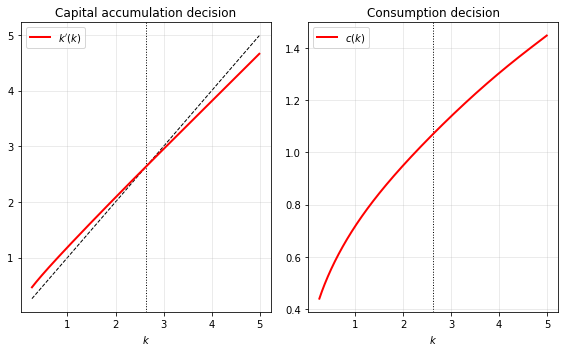

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))

ax[0].plot(K, K_opt, color='red', linewidth=2, zorder=2, label=r"$k'(k)$")
ax[1].plot(K, C1, color='red', linewidth=2, zorder=2, label=r'$c(k)$')
ax[0].plot(K, K, color='black', linewidth=1, linestyle='dashed', zorder=1)

ax[0].set_title('Capital accumulation decision')
ax[1].set_title('Consumption decision')

for a in range(2):
    ax[a].axvline(k_ss, color='black', linewidth=1, linestyle='dotted', zorder=1)
    ax[a].legend()
    ax[a].grid(alpha=0.3)
    ax[a].set_xlabel(r'$k$')

plt.tight_layout()

Note one thing here: we miss the value function.
Is this important? 
In most cases no, but if you want to carry out welfare analysis, you will need to compute $V(k)$.

To be sure: you can always compute the value function after PFI, but it will not be the by-product of the algorithm per se.

## Direct Projection

Sometimes, if your nonlinear model is simple enough, you can just feed it to an equation solver.

Most software packages like SciPy, Matlab, Mathematica and so on include those equation solvers by default.

However, this approach is _very_ sensitive to the initial condition, so that those equation solvers might be much more unstable than the previous methods.

### How can we do it?

This is simple: the module `scipy.optimize` contains a function called `fsolve`.
Find the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html).

In [22]:
from scipy.optimize import fsolve

Start from an initial guess $c^{(0)}(k)$.
Make sure this is good enough.

In [39]:
C0 = 0.4 + 0.35 * K - 0.02 * K**2

Define a Python function that returns the error associated to the Euler equation.

In [40]:
def euler(C0, K, alpha, beta, gamma, delta):
    k1 = K**alpha - C0 + (1-delta) * K
    pc = np.polyfit(K, C0, 1)
    Ctp1 = np.polyval(pc, k1)
    opr = alpha * k1 ** (alpha-1) + 1 - delta
    resid = C0 - Ctp1 * (beta * opr) ** (-1/gamma)
    return resid

This function compares the LHS and the RHS of the Euler equation and tells how much far apart they are.
The idea is to make them equal.

An equation solver takes an equation in form of a `function` handle and tries several values of the first argument (here, `C0`), until the equation is satisfied.
The solver returns the value of the first argument that solves the equation.

In [41]:
t0 = time()

C1 = fsolve(euler, C0, args=(K, alpha, beta, gamma, delta))
K_opt = K ** alpha - C1 + (1-delta) * K

t1 = time()

print('Direct projection took {:.2f} seconds.'.format(t1-t0))

Direct projection took 1.69 seconds.


Let's see what we have from this solution method.

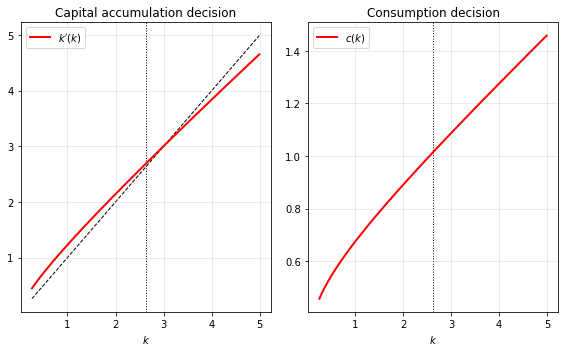

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

ax[0].plot(K, K_opt, color='red', linewidth=2, zorder=2, label=r"$k'(k)$")
ax[1].plot(K, C1, color='red',    linewidth=2, zorder=2, label=r'$c(k)$')
ax[0].plot(K, K, color='black',   linewidth=1, linestyle='dashed', zorder=1)

ax[0].set_title('Capital accumulation decision')
ax[1].set_title('Consumption decision')

for a in range(2):
    ax[a].axvline(k_ss, color='black', linewidth=1, linestyle='dotted', zorder=1)
    ax[a].legend()
    ax[a].grid(alpha=0.3)
    ax[a].set_xlabel(r'$k$')

plt.tight_layout()

This method works, but as we can see it is less perfect that the others.
The capital accumulation decision misses the correct value for the steady state.
Moreover, if you change the initial guess `C0`, you will see that the method might fail, or give different results (Economists call this a lack of robustness, Computer Scientists call this instability).